In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
# 读入数据
data = pd.read_csv('./data/airline-passengers.csv',parse_dates=[0])
time_series = data['Passengers']
time_series.index = pd.DatetimeIndex(data['Month'], freq='infer')
data

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:

t=sm.tsa.stattools.adfuller(time_series, )
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

                                value
Test Statistic Value         0.815369
p-value                      0.991880
Lags Used                          13
Number of Observations Used       130
Critical Value(1%)          -3.481682
Critical Value(5%)          -2.884042
Critical Value(10%)         -2.578770


In [4]:
time_series.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

由上表可知，t 统计量要大于任何置信度的临界值，因此认为该序列是非平稳的，所以再对序列进行差分处理，发现差分之后的序列基本达到稳定，如下图所示，并且通过了 ADF 检验，检验结果见下表。

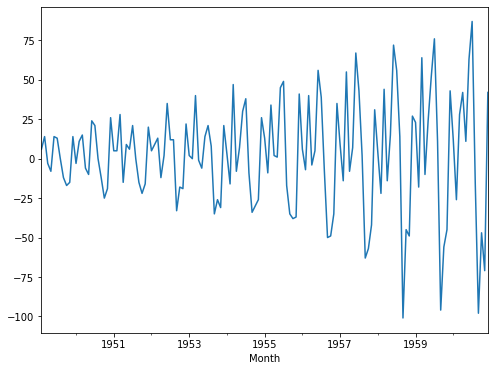

                                value
Test Statistic Value        -2.829267
p-value                      0.054213
Lags Used                          12
Number of Observations Used       130
Critical Value(1%)          -3.481682
Critical Value(5%)          -2.884042
Critical Value(10%)         -2.578770


In [5]:
time_series = time_series.diff(1)
time_series = time_series.dropna(how=any)
time_series.plot(figsize=(8,6))
plt.show()
t=sm.tsa.stattools.adfuller(time_series)
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

## 确定自相关系数和平均移动系数（p,q）
根据时间序列的识别规则，采用 ACF 图、PAC 图，AIC 准则（赤道信息量准则）和 BIC 准则（贝叶斯准则）相结合的方式来确定 ARMA 模型的阶数, 应当选取 AIC 和 BIC 值达到最小的那一组为理想阶数。


In [ ]:
plot_acf(time_series)
plot_pacf(time_series)
plt.show()

r,rac,Q = sm.tsa.acf(time_series, qstat=True)
prac = pacf(time_series,method='ywmle')
table_data = np.c_[range(1,len(r)), r[1:],rac,prac[1:len(rac)+1],Q]
table = pd.DataFrame(table_data, columns=['lag', "AC","Q", "PAC", "Prob(>Q)"])
table


根据上面的几个图，我们可以先取 p=1, q=2。进行模型估计,结果见下图。

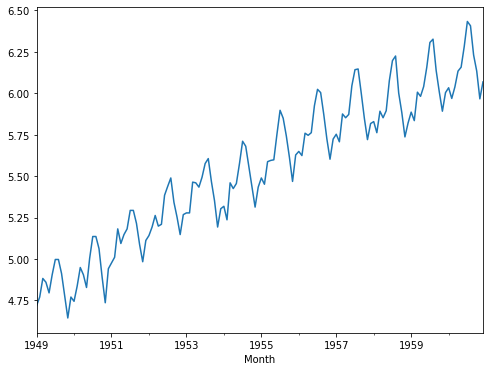

129 15


In [12]:
# time_series = data['Passengers']
# time_series.index=data['Month']
time_series = data['Passengers']
time_series.index = pd.DatetimeIndex(data['Month'], freq='infer')
time_series = np.log(time_series)
time_series.plot(figsize=(8,6))
plt.show()
train_size = len(time_series) - 15
train_data = time_series[:train_size]
test_data = time_series[train_size:]
print(len(train_data),len(test_data))

In [13]:
def get_pq2(df):
        """
        bic评估指标，自动定阶，需要注意的是，有些列找不到p,q,也就无法建模
        :param df: df
        :return: 最优的p和q
        """
        pmax = int(4)
        qmax = int(4)
        param_list = []
        for p in range(pmax + 1):
            for d in range(3):
                for q in range(qmax + 1):
                    try:
                        bic = ARIMA(df, (p, d, q),missing="drop").fit(disp=-1).bic
                        param_list.append((bic,((p, d, q))))
                    except:
                        pass
        print(list)
        if len(param_list)==0:
            return None,None,None
        """
       param_list=  [(1202.4238818829, (2, 0, 4)),
         (1206.309054876091, (2, 0, 2)),
         (1206.4792083382936, (3, 0, 4)),
         (1208.1163437591713, (0, 0, 4)),
        """
        param_list.sort(key=lambda x:x[0])
        print(param_list)
        return param_list[0][1]


In [14]:
p, d, q = get_pq2(train_data)
arma_mod = ARIMA(train_data,(p, d, q)).fit(disp=-1)
summary = (arma_mod.summary2(alpha=.05, float_format="%.8f"))
# print(summary)
summary

/Users/lcz/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/lcz/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/lcz/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lcz/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lcz/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lcz/minico

<class 'list'>
[(-241.5860125209727, (4, 1, 3)), (-238.11477741528677, (2, 1, 4)), (-236.94730935370242, (4, 1, 4)), (-233.3920409028379, (3, 1, 4)), (-231.96363872082145, (3, 1, 3)), (-230.95625775907243, (2, 1, 3)), (-230.4493579137381, (0, 1, 4)), (-226.10433246478613, (2, 1, 1)), (-225.6738238584401, (1, 1, 4)), (-223.67947650666042, (4, 1, 2)), (-223.43946215900874, (4, 1, 1)), (-223.00105387196174, (1, 1, 2)), (-222.67013033940506, (3, 1, 1)), (-221.4538131339844, (3, 0, 2)), (-220.8995061807092, (3, 1, 2)), (-219.16209208301652, (2, 1, 2)), (-218.1530933843121, (1, 1, 3)), (-217.14748856893004, (0, 1, 3)), (-216.5962802584938, (3, 0, 3)), (-214.40608857331875, (0, 1, 2)), (-205.8144082785286, (4, 1, 0)), (-205.39447396998384, (1, 1, 1)), (-203.16347578919803, (0, 1, 1)), (-202.42880107899876, (0, 1, 0)), (-201.4899972642455, (1, 1, 0)), (-201.2615646329752, (0, 2, 4)), (-200.634231678675, (2, 1, 0)), (-200.60324861653555, (4, 2, 3)), (-199.25725644082928, (2, 0, 1)), (-198.04641

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -241.5860 
Dependent Variable: D.Passengers     Log-Likelihood:      142.63    
Date:               2021-01-14 16:27 Scale:               1.0000    
No. Observations:   128              Method:              css-mle   
Df Model:           8                Sample:              02-01-1949
Df Residuals:       120                                   09-01-1959
Converged:          1.0000           S.D. of innovations: 0.076     
No. Iterations:     92.0000          HQIC:                -256.825  
AIC:                -267.2543                                       
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                0.0104   0.0004  24.1339 0.0000  0.0096  0.0112
ar.L1.D.Passengers   0.1906   0.0753   2.5311 0.0114  0.0430  0.3381
ar.L2.D.Passengers  -0.4150   0.0551  -7.5255 0.0000 -0.5231 -0.3069
ar.L3.D.Passengers   0.5841   0.0558  10.4669 0.0000  0.4747  0.6935
ar.L4.D.Passengers  -0.5594   0.0744  -7.5160 0.0000 -0.7053 -0.4135
ma.L1.D.Passengers  -0.1235   0.0455  -2.7175 0.0066 -0.2126 -0.0344
ma.L2.D.Passengers   0.1235   0.0445   2.7745 0.0055  0.0363  0.2108
ma.L3.D.Passengers  -1.0000   0.0434 -23.0654 0.0000 -1.0850 -0.9150
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -0.4976            -0.8796           1.0106            -0.3319
AR.2           -0.4976             0.8796           1.0106             0.3319
AR.3            1.0197            -0.8430           1.3230            -0.1099
AR.4            1.0197             0.8430           1.3230             0.1099
MA.1            1.0000            -0.0000           1.0000            -0.0000
MA.2           -0.4382            -0.8989           1.0000            -0.3222
MA.3           -0.4382             0.8989           1.0000             0.3222
====================================================================

"""

In [15]:
test_data

Month
1959-10-01    6.008813
1959-11-01    5.891644
1959-12-01    6.003887
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: Passengers, dtype: float64

In [16]:
redict_data = arma_mod.predict(start=test_data.index[0], end=test_data.index[-1])
redict_data

1959-10-01   -0.103972
1959-11-01   -0.060789
1959-12-01    0.097242
1960-01-01    0.100915
1960-02-01    0.014010
1960-03-01    0.064071
1960-04-01    0.023421
1960-05-01   -0.057918
1960-06-01    0.021308
1960-07-01    0.018416
1960-08-01   -0.039785
1960-09-01    0.042100
1960-10-01    0.035851
1960-11-01   -0.031701
1960-12-01    0.038406
Freq: MS, dtype: float64

In [ ]:
plt.plot?

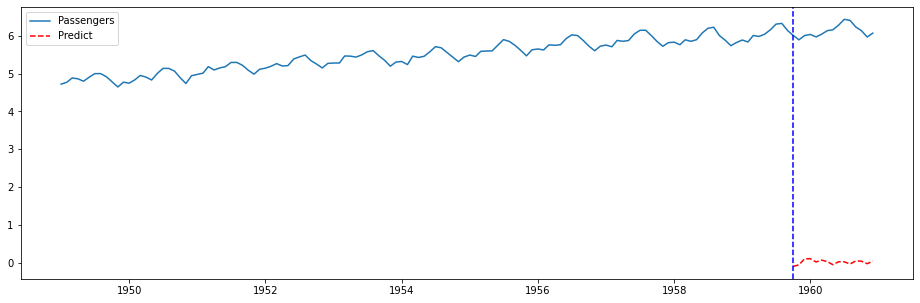

In [11]:
plt.figure(figsize=(16,5))
plt.plot(time_series.index,  time_series, linestyle='-',label='Passengers')
plt.plot(redict_data.index,redict_data,c='r', linestyle='--',label='Predict')
plt.axvline(x=test_data.index[0], c='b', linestyle='--')
plt.legend()#  是否显示图例
plt.show()